Import Lib

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn import preprocessing
import sklearn.feature_selection as fs
import pickle
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sys import stdout
import math
import plotly.express as px
import matplotlib as mpl
import matplotlib.patches as mpatches

In [ ]:
dataset = pd.read_csv ('/content/Raw_data_mid.csv')
print (dataset)


         R_610nm      S_680nm      T_730nm      U_760nm      V_810nm  \
0    6189.242188  9165.197266  13118.49414  15181.95801  30960.63281   
1    5635.516602  8591.493164  13357.27441  15381.11230  35937.54297   
2    5991.388184  7938.769043  11890.62988  13640.63770  34465.28516   
3    5516.007813  7958.253418  13066.00391  15148.92285  36151.74609   
4    6182.602539  8785.253906  13078.35449  14880.86719  32264.94727   
..           ...          ...          ...          ...          ...   
395  5874.534670  7997.221680  12603.88184  14660.94824  33726.14063   
396  6639.393070  9139.217770  12830.31152  14752.50293  35243.65234   
397  6086.995610  8732.212890  12325.99121  14333.42969  36186.94141   
398  6320.702150  8324.125000  12213.80566  14190.90723  36983.41016   
399  5999.355470  9589.522460  13868.79883  16108.82715  35134.03906   

         W_860nm  DATE location  weight  height       HU  
0    30443.13867     2      mid   62.38    0.70  82.7666  
1    34033.54297 

In [ ]:
dataset.describe()

,R_610nm,S_680nm,T_730nm,U_760nm,V_810nm,W_860nm,DATE,weight,height,HU
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,6007.634811,8128.841003,12172.482544,14126.705991,35553.293624,33525.688741,11.500000,59.262050,0.561100,72.326242
std,580.889668,828.472936,943.397663,1060.037925,1811.246744,1772.948001,5.773503,1.616967,0.157693,11.536155
min,4227.965332,5180.658203,7860.186523,9297.946289,25131.943360,23250.091800,2.000000,54.640000,0.300000,44.600300
25%,5628.545409,7586.427980,11556.903077,13453.281983,34657.112305,32575.284178,6.750000,58.120000,0.450000,64.391400
50%,5985.412842,8162.297119,12304.377440,14282.461910,35628.310545,33640.591795,11.500000,59.170000,0.500000,69.369900
75%,6337.964355,8703.257326,12849.609618,14866.709478,36746.331055,34711.104493,16.250000,60.167500,0.660000,80.616850
max,7846.434570,10216.266600,14568.670900,16681.748050,39484.433590,37081.648440,21.000000,64.190000,0.990000,98.851200


In [ ]:
mean= dataset.groupby('DATE', as_index=False)['T_730nm','U_760nm','V_810nm','W_860nm'].mean()
print(mean)

    DATE       T_730nm       U_760nm       V_810nm       W_860nm
0      2  11500.244629  13915.678321  31003.170801  29104.847558
1      3  11331.554640  13700.101026  31504.784082  29922.818262
2      4  11251.841406  13465.316260  34726.803516  32806.280078
3      5  10438.291015  12340.237402  33678.625489  31267.719629
4      6  10503.286377  12477.804785  34644.089845  32472.946388
5      7  10268.674754  12267.607422  34538.246192  32159.261035
6      8  10041.627930  11942.778808  32715.624512  30618.129687
7      9  10883.070214  13182.961182  33060.558888  31550.006055
8     10  10340.205812  12425.656495  34019.687988  32027.481837
9     11  10514.453466  12567.187988  34008.022365  32025.340138
10    12  10201.209130  12025.224855  34587.069923  31796.792969
11    13  10201.209130  12025.224855  34587.069923  31796.792969
12    14  10356.416113  12489.980469  34446.531934  32555.453810
13    15  10175.427051  12244.247021  33362.904590  31694.638087
14    16   9783.807226  1

<ipython-input-4-9d51b9a05a71>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean= dataset.groupby('DATE', as_index=False)['T_730nm','U_760nm','V_810nm','W_860nm'].mean()


# Mục mới

In [ ]:
def msc(input_data, reference=None):
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()

    # Get the reference spectrum. If not given, estimate it from the mean
    if reference is None:
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference

    # Define a new array and populate it with the corrected data
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0]

    return (data_msc, ref)

In [ ]:
def snv(input_data):

    # Define a new array and populate it with the corrected data
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):

        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])

    return output_data

In [ ]:
x = dataset.drop(columns=['R_610nm','S_680nm'], axis = 1)

print(x)

         T_730nm      U_760nm      V_810nm      W_860nm  DATE location  \
0    13118.49414  15181.95801  30960.63281  30443.13867     2      mid   
1    13357.27441  15381.11230  35937.54297  34033.54297     2      mid   
2    11890.62988  13640.63770  34465.28516  32531.52148     2      mid   
3    13066.00391  15148.92285  36151.74609  33882.97266     2      mid   
4    13078.35449  14880.86719  32264.94727  30228.91406     2      mid   
..           ...          ...          ...          ...   ...      ...   
395  12603.88184  14660.94824  33726.14063  32041.86523    21      mid   
396  12830.31152  14752.50293  35243.65234  33316.19531    21      mid   
397  12325.99121  14333.42969  36186.94141  34389.76563    21      mid   
398  12213.80566  14190.90723  36983.41016  34907.57813    21      mid   
399  13868.79883  16108.82715  35134.03906  34106.98828    21      mid   

     weight  height       HU  
0     62.38    0.70  82.7666  
1     61.62    0.80  88.9867  
2     60.00    0.8

In [ ]:
x.describe()

,T_730nm,U_760nm,V_810nm,W_860nm,DATE,weight,height,HU
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,10353.451953,12380.908240,33091.698648,31044.112022,11.500000,59.262050,0.561100,72.326242
std,725.226016,909.307633,1932.669822,1785.548000,5.773503,1.616967,0.157693,11.536155
min,8435.523440,10249.355470,27152.273440,25465.785160,2.000000,54.640000,0.300000,44.600300
25%,9802.075685,11687.795412,31818.693845,29937.875488,6.750000,58.120000,0.450000,64.391400
50%,10343.705075,12350.855955,33250.976565,31084.587890,11.500000,59.170000,0.500000,69.369900
75%,10865.264890,12979.229245,34527.887698,32332.599120,16.250000,60.167500,0.660000,80.616850
max,12239.536130,14918.622070,37285.101560,35863.632810,21.000000,64.190000,0.990000,98.851200


In [ ]:
df1 = pd.DataFrame(np.random.randint(0,100,size=(100, 4)), columns=list('ABCD'))
print (df1)

     A   B   C   D
0   72  41   5  40
1   31  41   5  30
2   64  69   4  30
3   73  44  96  98
4   44  79  39  53
..  ..  ..  ..  ..
95  98  57   6  69
96  99  90  18  76
97  63  24  13  88
98  62  35  97  38
99  50  72  60  97

[100 rows x 4 columns]


In [ ]:
#Data Processing
df = pd.DataFrame(dataset)
#df.to_csv(r'/content/Standard.csv',index = False, header = False)
x_original = df.iloc[:,[2,3,4,5]]
y_original = df.iloc[:,10]
scaler = StandardScaler()
scaler.fit(x_original)
standardized_data = scaler.transform(x_original)
x_std= standardized_data
df1 = pd.DataFrame(x_std)
df2 = df1.describe()
x_original.to_csv(r'/content/Original.csv',index = False, header = False)
df1.to_csv(r'/content/Standard.csv',index = False, header = False)
df2.to_csv(r'/content/Describe.csv',index = False, header = False)
print(y_original)
print(x_original)
print(x_std)

0      82.7666
1      88.9867
2      89.4133
3      94.6290
4      97.2217
        ...   
395    61.1051
396    59.5165
397    55.8296
398    56.0707
399    49.0764
Name: HU, Length: 400, dtype: float64
         T_730nm      U_760nm      V_810nm      W_860nm
0    11722.86621  14231.49316  31323.66797  29913.08594
1    11355.43262  13576.45605  31734.97461  29063.53320
2    11216.48730  13591.55762  30929.45703  29417.30859
3    11101.21387  13731.24805  33529.03516  31883.95117
4    11370.87109  13888.87305  30386.41211  28551.84180
..           ...          ...          ...          ...
395   9460.63086  11482.03418  31115.50000  29549.51758
396  10044.20117  12064.39453  31823.47070  29963.27539
397  10021.55762  12027.58398  32170.41602  30466.39844
398  10051.40527  12238.06445  32025.60547  30952.38086
399   9846.58984  11987.94238  31565.02148  30046.51758

[400 rows x 4 columns]
[[ 1.89062335  2.03770697 -0.91595825 -0.63422687]
 [ 1.38334185  1.31643573 -0.70287388 -1.11061657]

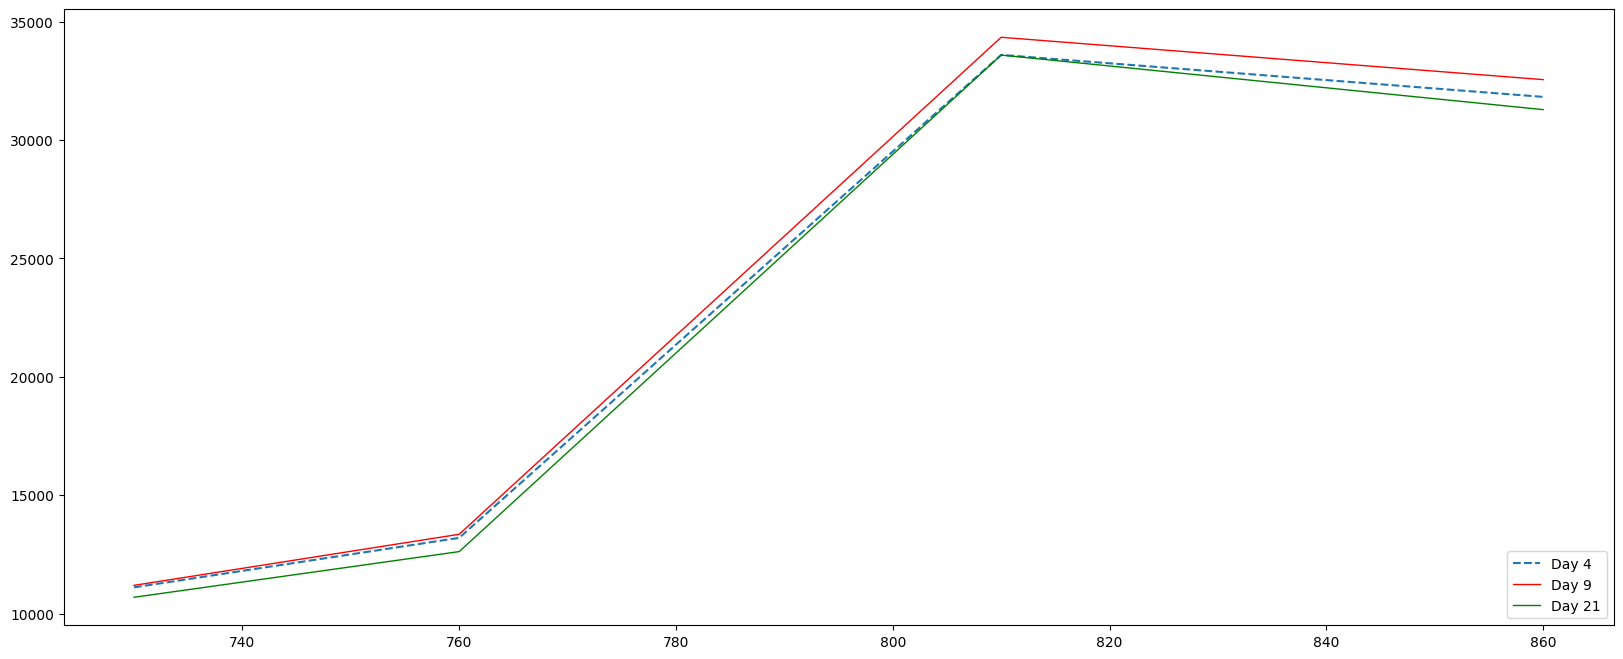

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
line1, = ax.plot(wl, day2.T, label="Day 4", linestyle='--')
line2, = ax.plot(wl, day9.T, label="Day 9", linewidth=1,color='red')
line3, = ax.plot(wl, day21.T, label="Day 21", linewidth=1,color='green')

# Create another legend for the second line.
ax.legend(handles=[line1,line2,line3,], loc='lower right')

plt.show()

In [ ]:
nv=x_original.values
Xsnv=snv(nv)
Xmsc=msc(nv)[0]
print(Xmsc)

[[-11807.82737121  -8867.70902169  11164.37139265   9511.16500025]
 [-11589.2700517   -9034.97660806  11848.27220307   8775.97445669]
 [-11721.42762618  -8957.46618006  11219.31979652   9459.57400972]
 ...
 [-11381.31745076  -9333.66154967  11227.17938137   9487.79961906]
 [-11483.49979773  -9254.51819785  10916.00734351   9822.01065207]
 [-11472.03082285  -9241.81539284  11147.68286483   9566.16335085]]


In [ ]:
print (x_std)
print (y_original)

[[ 1.89062335  2.03770697 -0.91595825 -0.63422687]
 [ 1.38334185  1.31643573 -0.70287388 -1.11061657]
 [ 1.19151292  1.33306429 -1.12018591 -0.91223577]
 ...
 [-0.45821575 -0.38905067 -0.47728608 -0.32395493]
 [-0.41700786 -0.15728745 -0.55230763 -0.05143857]
 [-0.69977755 -0.43270064 -0.79092098 -0.55940461]]
0      82.7666
1      88.9867
2      89.4133
3      94.6290
4      97.2217
        ...   
395    61.1051
396    59.5165
397    55.8296
398    56.0707
399    49.0764
Name: HU, Length: 400, dtype: float64


In [ ]:
print(x_std)
print(y_original)

[[ 1.89062335  2.03770697 -0.91595825 -0.63422687]
 [ 1.38334185  1.31643573 -0.70287388 -1.11061657]
 [ 1.19151292  1.33306429 -1.12018591 -0.91223577]
 ...
 [-0.45821575 -0.38905067 -0.47728608 -0.32395493]
 [-0.41700786 -0.15728745 -0.55230763 -0.05143857]
 [-0.69977755 -0.43270064 -0.79092098 -0.55940461]]
0      82.7666
1      88.9867
2      89.4133
3      94.6290
4      97.2217
        ...   
395    61.1051
396    59.5165
397    55.8296
398    56.0707
399    49.0764
Name: HU, Length: 400, dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_std,y_original,test_size = 0.2)

Training model

In [ ]:
from sklearn.linear_model import LinearRegression
ml = LinearRegression()
ml.fit(x_train,y_train)
y_pred = ml.predict(x_test)
from sklearn.metrics import r2_score
r2=r2_score(y_test, y_pred)
mse = mean_squared_error(y_test,y_pred)
Rmse=math.sqrt(mse)
print(Rmse)
print(r2)

9.202748349552357
0.34542958626496134


In [ ]:
y_pred = ml.predict(x_test)


In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.34542958626496134

In [ ]:
mse = mean_squared_error(y_test,y_pred)
Rmse=math.sqrt(mse)
print(Rmse)

9.202748349552357


In [ ]:
ML_Model = 'model1.sav'
pickle.dump(ml, open(ML_Model, 'wb'))

In [ ]:
SC_Model = 'scaler1.sav'
pickle.dump(scaler, open(SC_Model, 'wb'))

In [ ]:
loaded_model_ML = pickle.load(open(ML_Model, 'rb'))
loaded_model_SC = pickle.load(open(SC_Model, 'rb'))

